Import Packages

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
import statsmodels.api as sm

Read in Voting and Challenge Data

In [45]:
path = '/workspaces/myfolder/survivor_data.csv'
survivor = pd.read_csv(path)

I want to ensure my data looks correct by ensuring there are 47 winners for 47 seasons. I also create a binary variable to flag winners and create a separate dataframe with only the Survivor winners.

In [46]:
survivor['Winner'] = survivor['Finish']==1
survivor['Winner'].value_counts()

Winner
False    810
True      47
Name: count, dtype: int64

In [47]:
winners = survivor[survivor['Winner'] == 1]

Spoilers ahead! I made a list of the winner for each season.

In [48]:
print(winners[['Season','contestant']])

     Season          contestant
0         1       Richard Hatch
16        2         Tina Wesson
32        3          Ethan Zohn
48        4      Vecepia Towery
64        5        Brian Heidik
80        6       Jenna Morasca
96        7   Sandra Diaz-Twine
112       8        Amber Brkich
130       9     Chris Daugherty
148      10         Tom Westman
168      11    Danni Boatwright
186      12     Aras Baskauskas
202      13            Yul Kwon
222      14           Earl Cole
241      15         Todd Herzog
257      16     Parvati Shallow
277      17         Bob Crowley
295      18         J.T. Thomas
311      19       Natalie White
331      20   Sandra Diaz-Twine
351      21         Fabio Birza
371      22  Boston Rob Mariano
390      23       Sophie Clarke
407      24        Kim Spradlin
426      25      Denise Stapley
443      26        John Cochran
463      27       Tyson Apostol
483      28        Tony Vlachos
501      29    Natalie Anderson
519      30       Mike Holloway
543     

How many male and female winners have there been? 

In [49]:
winners.loc[:, 'Sex'] = winners['Sex'].str.upper()
winners['Sex'].value_counts()

Sex
M    26
F    21
Name: count, dtype: int64

We see that male winners are slightly more common, with 26 male winners and 21 female winners.

### Individual immunity challenge stats

Of the winners, which are the challenge beasts? First, a list of winners with four or more individual immunity challenge wins.

In [50]:
challenge_winners = winners[winners['InICW'] >= 4][['Season', 'contestant', 'InICW']].sort_values(by='InICW', ascending=False)
challenge_winners.columns = ['Season', 'Contestant', 'Number of Individual Immunity Challenge Wins']
challenge_winners

,Season,Contestant,Number of Individual Immunity Challenge Wins
148,10,Tom Westman,5
519,30,Mike Holloway,5
351,21,Fabio Birza,4
80,6,Jenna Morasca,4
371,22,Boston Rob Mariano,4
407,24,Kim Spradlin,4
711,40,Tony Vlachos,4
848,47,Rachel LaMont,4


Next, let's look at the entire dataset, not just winners. Which are the elite Survivor competitors with FIVE immunity challenge wins? 

In [51]:
survivor[survivor['InICW'] >= 5][['Season', 'contestant', 'InICW']].sort_values(by='InICW', ascending=False)

,Season,contestant,InICW
17,2,Colby Donaldson,5
148,10,Tom Westman,5
188,12,Terry Deitz,5
203,13,Ozzy Lusth,5
519,30,Mike Holloway,5
595,34,Brad Culpepper,5


### Team Challenge Stats

Of the winners, which were able to win without ever winning a team immunity challenge? 
With the exception of Chris Underwood in season 38 who spent much of the season in exile, this means that these players had to participate in every tribal council the entire season. 
It also means they had the fewest possible former tribe mates on the jury. 

In [52]:
team_losers = winners[winners['TICW']==0][['Season', 'contestant']]
team_losers.columns = ['Season', 'Contestant']
team_losers

,Season,Contestant
426,25,Denise Stapley
674,38,Chris Underwood
790,44,Yam Yam Arocho


### Voting Record Stats

Let's look at the vote for boot percentage for the winners. Out of all the tribal councils these winners participated in, in how many did they vote for the person who went home? Put simply, how often were these players on the right side of the vote? 

In [53]:
#convert VFB% to a numeric
winners.loc[:,'VFB%'] = winners['VFB%'].astype(float)

Which winners had a perfect record? (100%)

In [54]:
vote_record = winners[winners['VFB%']==1][['Season', 'contestant']]
vote_record.columns = ['Season', 'Contestant']
vote_record

,Season,Contestant
16,2,Tina Wesson
32,3,Ethan Zohn
64,5,Brian Heidik
112,8,Amber Brkich
202,13,Yul Kwon
241,15,Todd Herzog
257,16,Parvati Shallow
311,19,Natalie White
483,28,Tony Vlachos


In [55]:
winners['VFB%'].min()

0.44

Which winners had the lowest record? (<=70%)

In [56]:
winners[winners['VFB%']<=.7][['Season', 'contestant', 'VFB%']].sort_values(by='VFB%')

,Season,contestant,VFB%
816,45,Dee Valladares,0.44
277,17,Bob Crowley,0.56
351,21,Fabio Birza,0.6
543,31,Jeremy Collins,0.64
443,26,John Cochran,0.67
572,32,Michele Fitzgerald,0.67
711,40,Tony Vlachos,0.67
790,44,Yam Yam Arocho,0.7
848,47,Rachel LaMont,0.7


I was also curious how this has changed over time. I would assume that as the game has gotten more complicated, voting for the correct person every time would become more difficult. In the plot, we see a slight downward trend in voting record. 

Text(0, 0.5, 'Vote for Boot %')

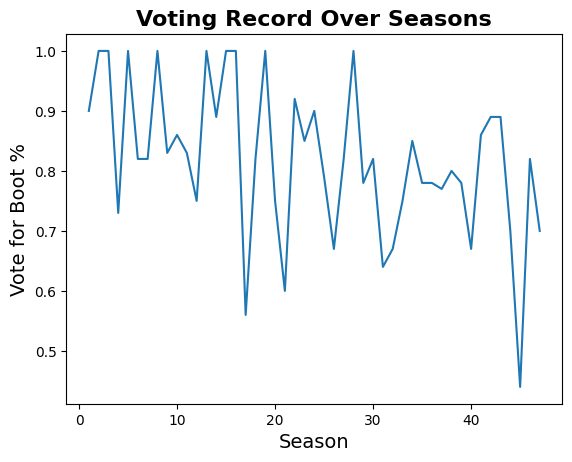

In [57]:
plt.plot(winners['Season'], winners['VFB%'])

# Add title and labels
plt.title('Voting Record Over Seasons', fontsize=16, fontweight='bold')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Vote for Boot %', fontsize=14)

### Votes Against Player Stats 

How many votes did the winners receive without going home? First, these are the players who received the most votes over the course of their season. 

In [58]:
winners[winners['VAP']>=6][['Season', 'contestant', 'VAP']].sort_values(by='VAP', ascending=False)

,Season,contestant,VAP
186,12,Aras Baskauskas,9
0,1,Richard Hatch,6
112,8,Amber Brkich,6
371,22,Boston Rob Mariano,6
426,25,Denise Stapley,6
575,33,Adam Klein,6
790,44,Yam Yam Arocho,6


Here are the players who never received a single vote.

In [59]:
winners[winners['VAP']==0][['Season', 'contestant', 'VAP']]

,Season,contestant,VAP
16,2,Tina Wesson,0
32,3,Ethan Zohn,0
64,5,Brian Heidik,0
96,7,Sandra Diaz-Twine,0
148,10,Tom Westman,0
295,18,J.T. Thomas,0
443,26,John Cochran,0
501,29,Natalie Anderson,0
519,30,Mike Holloway,0
543,31,Jeremy Collins,0


### Incorporating Idol Data

In addition to voting and challenges, immunity idols are a huge part of the game. Which winners found the most idols and played them successfully? 

First, I read in the data and did some cleaning.

In [60]:
#reading in idol data
idol_data = pd.read_csv('/workspaces/myfolder/survivor_idols.csv')

#renaming contestant column to merge with survivor dataset
idol_data.rename(columns={'Contestant': 'contestant'}, inplace=True)

#Limiting to needed information
idol_data = idol_data.iloc[:196]

#removing dashes and digits from names
idol_data['contestant'] = idol_data['contestant'].apply(lambda x: re.sub(r'(?<=\d)-|-(?=\d)|\d', '', str(x)) if isinstance(x, str) else str(x))
idol_data['Season'] = idol_data['Season'].apply(lambda x: re.sub(r'S', '', str(x)) if isinstance(x, str) else str(x))

#changing season to numeric
idol_data['Season'] = idol_data['Season'].astype(float)

Roll up idol data to include only one row per player and season - include number of idols found, played, number of votes voided, boots voided, and max time between day found and played

In [61]:
#Change columns to numeric
idol_data[['Idols found', 'Idols played', 'Votes voided', 'Boot avoided']] = idol_data[['Idols found', 'Idols played', 'Votes voided', 'Boot avoided']].astype(float)

#Roll up idol data by contestant and season 
idol_data_grouped = idol_data.groupby(['contestant', 'Season']).agg(
    idols_found=('Idols found', 'sum'),  # Sum up idols found
    idols_played=('Idols played', 'sum'),  # Sum up idols played
    votes_voided=('Votes voided', 'sum'),  # Sum up votes voided
    boots_avoided=('Boot avoided', 'sum'),  # Sum up boots voided
    max_time_held=('Day played', lambda x: (x - idol_data.loc[x.index, 'Day found']).max())  # Max time between day found and played
)



Merge existing contestant and winner data with the idol information.

In [62]:
survivor_w_idols = pd.merge(survivor, idol_data_grouped, on=['contestant','Season'], how='left')
winners_w_idols = pd.merge(winners, idol_data_grouped, on=['contestant','Season'], how='left')


Which winners found the most idols in a single season?

In [63]:
winners_w_idols[winners_w_idols['idols_found']>=2][['Season', 'contestant', 'idols_found']].sort_values(by='idols_found', ascending=False)

,Season,contestant,idols_found
27,28,Tony Vlachos,3.0
34,35,Ben Driebergen,3.0
26,27,Tyson Apostol,2.0
30,31,Jeremy Collins,2.0
32,33,Adam Klein,2.0
41,42,Maryanne Oketch,2.0


Without isolating to only winners, which contestants found the most idols in one season?

In [64]:
survivor_w_idols[survivor_w_idols['idols_found']>=3][['Season', 'contestant', 'idols_found']].sort_values(by='idols_found', ascending=False)

,Season,contestant,idols_found
675,38,Rick Devens,4.0
312,19,Russell Hantz,3.0
483,28,Tony Vlachos,3.0
602,34,Tai Trang,3.0
615,35,Ben Driebergen,3.0
704,39,Kellee Kim,3.0


While finding idols is impressive, they only help in the game if you *know how to use them.* Which winners used their idol to avoid being voted out?

In [65]:
winners_w_idols[winners_w_idols['boots_avoided']>=1][['Season', 'contestant', 'boots_avoided']].sort_values(by='boots_avoided', ascending=False)

,Season,contestant,boots_avoided
34,35,Ben Driebergen,2.0
28,29,Natalie Anderson,1.0
29,30,Mike Holloway,1.0
30,31,Jeremy Collins,1.0
37,38,Chris Underwood,1.0
46,47,Rachel LaMont,1.0


And of all contestants, who avoided being voted out using an idol **the most?**

In [66]:
survivor_w_idols[survivor_w_idols['boots_avoided']>=2][['Season', 'contestant', 'boots_avoided']].sort_values(by='boots_avoided', ascending=False)

,Season,contestant,boots_avoided
602,34,Tai Trang,3.0
615,35,Ben Driebergen,2.0
675,38,Rick Devens,2.0


## Model Building
##### Now that we've explored our data, we want to see if we can create a model to predict the winner of the season based off of their stats! 

### Feature Engineering
Any long-time viewer of the show will know that the game has changed dramatically over time. What used to be a simple survival show has become a complex game of deceit full of twists, advantages, and strategy. To account for this in modeling, I created some flags for different milestones in the game: the introduction of immunity idols, the fire challenge, and the so-called "new era" after season 40 (if you know you know). I also flagged any seasons that included returners, where I'd expect gameplay to be significantly different. 

In [67]:
#Feature engineering: new era flag, idols in play flag, fire challenge flag, returners season flag 
survivor_w_idols['new_era'] = survivor_w_idols['Season']>=41
survivor_w_idols['idols_in_play'] = survivor_w_idols['Season']>=11
survivor_w_idols['fire_challenge'] = survivor_w_idols['Season']>=35
returner_seasons = [8,11,16,20,22,23,25,26,27,31,34,38,40]
survivor_w_idols['returners'] = survivor_w_idols['Season'].apply(lambda x: 1 if x in returner_seasons else 0)

In [68]:
survivor_w_idols = survivor_w_idols.replace('#DIV/0!', 0)
survivor_w_idols = survivor_w_idols.fillna(0)

I prepare the data for modeling by establishing my list of features, create my target (winner), and split into training and testing data. For my train-test split, I divide by season, since we want to be able to identify the winner of a season without training on anyone else from that season.

In [69]:
#Columns to use for model building: 
#VAP, VFB%, InChW%, TChW%, TRCW, idols_played, boots_avoided, new_era, idols_in_play, fire_challenge, returners

In [70]:
features = ['VAP', 'VFB%', 'InChW%', 'TChW%', 'TRCW', 'idols_played', 'boots_avoided', 'new_era', 'idols_in_play', 'fire_challenge', 'returners', 'Season']
target = ['Winner', 'Season']

# Split the dataset into features and target
X = survivor_w_idols[features]
y = survivor_w_idols[target]

# Set a random seed for reproducibility (optional)
np.random.seed(42)

# Shuffle the dataset based on seasons randomly
unique_seasons = X['Season'].unique()
np.random.shuffle(unique_seasons)

# Choose the first 70% of the unique seasons for the training set and the remaining 30% for the testing set
train_seasons = unique_seasons[:int(0.7 * len(unique_seasons))]
test_seasons = unique_seasons[int(0.7 * len(unique_seasons)):]

# Split data based on the random seasons
X_train = X[X['Season'].isin(train_seasons)]
X_test = X[X['Season'].isin(test_seasons)]
y_train = y[y['Season'].isin(train_seasons)]
y_test = y[y['Season'].isin(test_seasons)]

# Drop the 'Season' column as it's no longer needed
X_train = X_train.drop(columns=['Season'])
X_test = X_test.drop(columns=['Season'])
y_train = y_train.drop(columns=['Season'])
y_test = y_test.drop(columns=['Season'])

features = ['VAP', 'VFB%', 'InChW%', 'TChW%', 'TRCW', 'idols_played', 'boots_avoided', 'new_era', 'idols_in_play', 'fire_challenge', 'returners']


Since there is only one winner per season and ~20 players, we have a rare event target. To account for this, I use SMOTE to balance events and non-events. 

In [71]:
# Oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [72]:
X_resampled = X_resampled[features].astype(float)
X_test = X_test[features].astype(float)

I am using XGBoost for my model. I am using GridSearchCV to find the optimal hyperparameters for the model. 

In [73]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [10, 20, 30],        # Number of trees
    'max_depth': [1, 2, 3],               # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Learning rate (shrinkage)
    'subsample': [0.8, 0.9, 1.0],           # Subsample ratio of the training set
    'colsample_bytree': [0.8, 0.9, 1.0],   # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 1],              # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]              # L2 regularization term on weights
}

# Initialize the XGBoost classifier
model = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_resampled, y_resampled)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
print(f"Test accuracy: {best_model.score(X_test, y_test)}")


Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9}
Test accuracy: 0.8795620437956204


Once I've created the model, I look at the AUC score to determine how well my model is performing and visualize the ROC curve to determine the best cutoff.

In [74]:
# Get prediction probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)
y_test = y_test.astype(float)


# Calculate accuracy
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}%")

AUC: 0.7792792792792792%


AUC: 0.78


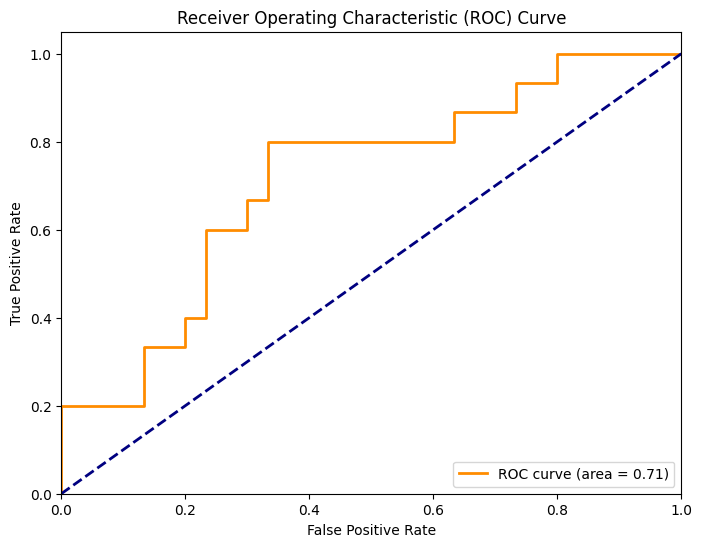

In [113]:
# Calculate AUC using probabilities
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

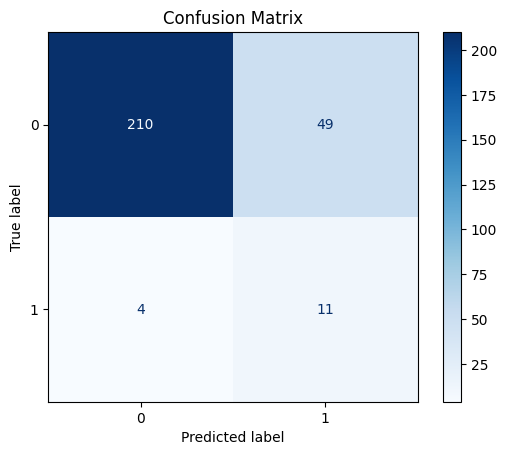

In [76]:
# Adjust the threshold manually
threshold = 0.3  # Lower threshold increases sensitivity to rare events
y_pred_adjusted = (y_proba >= threshold).astype(float)


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Looking at the confusion matrix, we see that our model is doing a pretty good job of predicting which contestants are unlikely to be winners based on their stats and which contestants are in the running for a winner status. However, for the purposes of predicting the winner *this isn't helpful.* Since the stats are only determined when the gameplay is complete and the jury is determining who should win, it is likely that *all of the players have good stats* just based off of the fact that they *haven't yet been voted out.* Thus, we want to adjust the model to predict who will win **between finalists.**

First, I'll test my theory and see how well our current model is predicting between finalists. To do so, I'll list the winner of each season and compare that to the predicted winner based on the probability from the model.

In [77]:
finalists = survivor_w_idols[survivor_w_idols['Finish']<4]
warnings.filterwarnings("ignore")

win_probabilities = []

features = ['VAP', 'VFB%', 'InChW%', 'TChW%', 'TRCW', 'idols_played', 'boots_avoided', 'new_era', 'idols_in_play', 'fire_challenge', 'returners']


for index, row in finalists.iterrows():
    # Extract the features for the current contestant
    contestant_features = row[features].values.reshape(1, -1)

    # Predict the probability of winning for this contestant
    prob = best_model.predict_proba(contestant_features)[:, 1]  # Get probability of winning (class 1)

    # Append the predicted probability to the list
    win_probabilities.append(prob[0])

finalists['win_probability'] = win_probabilities
predicted_winners = []

# Group by season
for season, group in finalists.groupby('Season'):
    # Get the player with the highest predicted win probability for this season
    predicted_winner = group.loc[group['win_probability'].idxmax()]
    
    # Append the top player to the list
    predicted_winners.append(predicted_winner[['contestant', 'Season']])

# Create a new DataFrame with the top players
predicted_winners_df = pd.DataFrame(predicted_winners)
predicted_winners_df.rename(columns={'contestant':'predicted_winner'}, inplace=True)

predicted_vs_actual = pd.merge(winners, predicted_winners_df, how='inner', on='Season')

predicted_vs_actual.rename(columns={'contestant':'winner'}, inplace=True)

predicted_vs_actual = predicted_vs_actual[['Season', 'winner', 'predicted_winner']]
predicted_vs_actual['correct'] = predicted_vs_actual['winner'] == predicted_vs_actual['predicted_winner']
print(predicted_vs_actual)

    Season              winner    predicted_winner  correct
0        1       Richard Hatch   Kelly Wiglesworth    False
1        2         Tina Wesson         Tina Wesson     True
2        3          Ethan Zohn          Ethan Zohn     True
3        4      Vecepia Towery      Vecepia Towery     True
4        5        Brian Heidik        Brian Heidik     True
5        6       Jenna Morasca       Jenna Morasca     True
6        7   Sandra Diaz-Twine   Sandra Diaz-Twine     True
7        8        Amber Brkich  Boston Rob Mariano    False
8        9     Chris Daugherty     Chris Daugherty     True
9       10         Tom Westman         Tom Westman     True
10      11    Danni Boatwright    Danni Boatwright     True
11      12     Aras Baskauskas  Danielle DiLorenzo    False
12      13            Yul Kwon          Ozzy Lusth    False
13      14           Earl Cole           Earl Cole     True
14      15         Todd Herzog       Amanda Kimmel    False
15      16     Parvati Shallow       Ama

I'll isolate to the test seasons to see how well the model is doing on the test data. We see that we have a 47% success rate, which is only slightly better than if we chose randomly between the three finalists.

In [78]:
predicted_vs_actual['set_type'] = predicted_vs_actual['Season'].apply(
    lambda x: 'train' if x in train_seasons else 'test'
)

# Print the updated predicted_vs_actual DataFrame
table = predicted_vs_actual[predicted_vs_actual['set_type']=='test'].reset_index()
table.columns = ['Season', 'Winner', 'Predicted Winner', 'Correct', 'Train or Test']

,Season,winner,predicted_winner,correct,set_type
2,3,Ethan Zohn,Ethan Zohn,True,test
7,8,Amber Brkich,Boston Rob Mariano,False,test
10,11,Danni Boatwright,Danni Boatwright,True,test
14,15,Todd Herzog,Amanda Kimmel,False,test
18,19,Natalie White,Russell Hantz,False,test
20,21,Fabio Birza,Sash Lenahan,False,test
21,22,Boston Rob Mariano,Natalie Tenerelli,False,test
22,23,Sophie Clarke,Albert Destrade,False,test
23,24,Kim Spradlin,Kim Spradlin,True,test
28,29,Natalie Anderson,Natalie Anderson,True,test


To see if I can adjust this model, I'll repeat the modeling process, training and testing only on finalists instead of the entire group.

In [100]:
finalists = survivor_w_idols[survivor_w_idols['Finish']<4]

features = ['VAP', 'VFB%', 'InChW%', 'TChW%', 'TRCW', 'idols_played', 'boots_avoided', 'new_era', 'idols_in_play', 'fire_challenge', 'returners', 'Season']
target = ['Winner', 'Season']

# Split the dataset into features and target
X = finalists[features].astype(float)
y = finalists[target].astype(float)

# Set a random seed for reproducibility (optional)
np.random.seed(27)

# Shuffle the dataset based on seasons randomly
unique_seasons = X['Season'].unique()
np.random.shuffle(unique_seasons)

# Choose the first 70% of the unique seasons for the training set and the remaining 30% for the testing set
train_seasons = unique_seasons[:int(0.7 * len(unique_seasons))]
test_seasons = unique_seasons[int(0.7 * len(unique_seasons)):]

# Split data based on the random seasons
X_train = X[X['Season'].isin(train_seasons)]
X_test = X[X['Season'].isin(test_seasons)]
y_train = y[y['Season'].isin(train_seasons)]
y_test = y[y['Season'].isin(test_seasons)]

# Drop the 'Season' column as it's no longer needed
X_train = X_train.drop(columns=['Season'])
X_test = X_test.drop(columns=['Season'])
y_train = y_train.drop(columns=['Season'])
y_test = y_test.drop(columns=['Season'])

features = ['VAP', 'VFB%', 'InChW%', 'TChW%', 'TRCW', 'idols_played', 'boots_avoided', 'new_era', 'idols_in_play', 'fire_challenge', 'returners']


In [101]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [10, 20, 30],        # Number of trees
    'max_depth': [1, 2, 3],               # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Learning rate (shrinkage)
    'subsample': [0.8, 0.9, 1.0],           # Subsample ratio of the training set
    'colsample_bytree': [0.8, 0.9, 1.0],   # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 1],              # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]              # L2 regularization term on weights
}

# Initialize the XGBoost classifier
model = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
print(f"Test accuracy: {best_model.score(X_test, y_test)}")

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Test accuracy: 0.6666666666666666


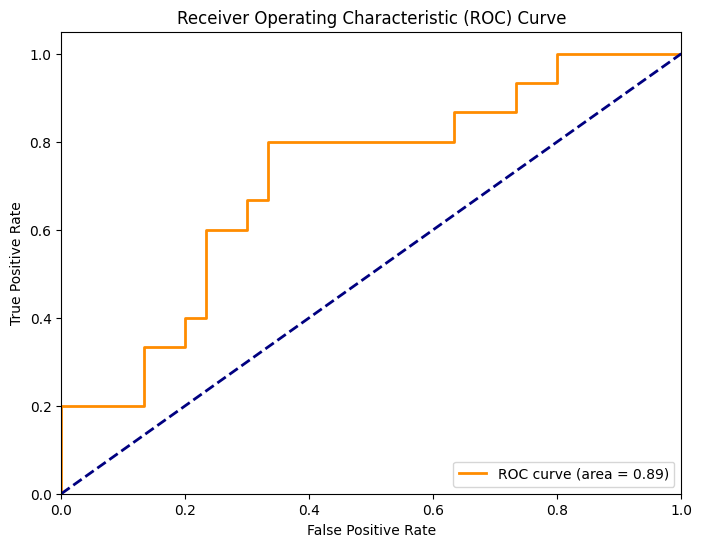

In [106]:
# Get prediction probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)
y_test = y_test.astype(float)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

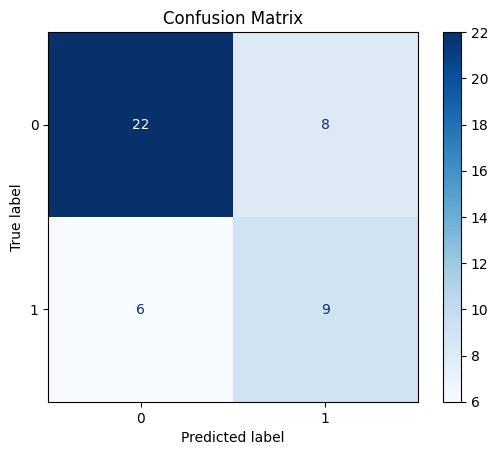

In [107]:
# Adjust the threshold manually
threshold = 0.35  # Lower threshold increases sensitivity to rare events
y_pred_adjusted = (y_proba >= threshold).astype(float)


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [108]:
win_probabilities = []

for index, row in finalists.iterrows():
    # Extract the features for the current contestant
    contestant_features = row[features].values.reshape(1, -1)

    # Predict the probability of winning for this contestant
    prob = best_model.predict_proba(contestant_features)[:, 1]  # Get probability of winning (class 1)

    # Append the predicted probability to the list
    win_probabilities.append(prob[0])

finalists['win_probability'] = win_probabilities
predicted_winners = []

# Group by season
for season, group in finalists.groupby('Season'):
    # Get the player with the highest predicted win probability for this season
    predicted_winner = group.loc[group['win_probability'].idxmax()]
    
    # Append the top player to the list
    predicted_winners.append(predicted_winner[['contestant', 'Season']])

# Create a new DataFrame with the top players
predicted_winners_df = pd.DataFrame(predicted_winners)
predicted_winners_df.rename(columns={'contestant':'predicted_winner'}, inplace=True)

predicted_vs_actual = pd.merge(winners, predicted_winners_df, how='inner', on='Season')

predicted_vs_actual.rename(columns={'contestant':'winner'}, inplace=True)

predicted_vs_actual = predicted_vs_actual[['Season', 'winner', 'predicted_winner']]
predicted_vs_actual['correct'] = predicted_vs_actual['winner'] == predicted_vs_actual['predicted_winner']
print(predicted_vs_actual)

    Season              winner    predicted_winner  correct
0        1       Richard Hatch       Richard Hatch     True
1        2         Tina Wesson         Tina Wesson     True
2        3          Ethan Zohn          Ethan Zohn     True
3        4      Vecepia Towery      Vecepia Towery     True
4        5        Brian Heidik        Brian Heidik     True
5        6       Jenna Morasca       Jenna Morasca     True
6        7   Sandra Diaz-Twine   Sandra Diaz-Twine     True
7        8        Amber Brkich        Amber Brkich     True
8        9     Chris Daugherty     Chris Daugherty     True
9       10         Tom Westman         Tom Westman     True
10      11    Danni Boatwright    Danni Boatwright     True
11      12     Aras Baskauskas     Aras Baskauskas     True
12      13            Yul Kwon          Ozzy Lusth    False
13      14           Earl Cole  Cassandra Franklin    False
14      15         Todd Herzog         Todd Herzog     True
15      16     Parvati Shallow       Ama

In [112]:
predicted_vs_actual['set_type'] = predicted_vs_actual['Season'].apply(
    lambda x: 'train' if x in train_seasons else 'test'
)

# Print the updated predicted_vs_actual DataFrame
table = predicted_vs_actual[predicted_vs_actual['set_type']=='test']
table.columns = ['Season', 'Winner', 'Predicted Winner', 'Correct', 'Set Type']
table

,Season,Winner,Predicted Winner,Correct,Set Type
2,3,Ethan Zohn,Ethan Zohn,True,test
4,5,Brian Heidik,Brian Heidik,True,test
8,9,Chris Daugherty,Chris Daugherty,True,test
10,11,Danni Boatwright,Danni Boatwright,True,test
13,14,Earl Cole,Cassandra Franklin,False,test
15,16,Parvati Shallow,Amanda Kimmel,False,test
19,20,Sandra Diaz-Twine,Russell Hantz,False,test
24,25,Denise Stapley,Mike Skupin,False,test
25,26,John Cochran,John Cochran,True,test
31,32,Michele Fitzgerald,Aubry Bracco,False,test


We see that once again, our model only predicts the winner about 40% of the time. While it's disappointing to not be able to guess the winner correctly every time (and brag to my friends and family about my skills), it's interesting to see that the winner isn't determined solely by how well they do at challenges, voting, and idol play. There must be something intangible about these players that makes them a sole survivor!!

To test this final theory, I created a logistic regression to see which factors are most statistically significant in determining a winner between the finalists.

In [94]:
finalists = survivor_w_idols[survivor_w_idols['Finish']<4]

features = ['VAP', 'VFB%', 'InChW%','TChW%', 'idols_played']
#, 'new_era', 'idols_in_play', 'fire_challenge', 'returners']
target = 'Winner' 

# Split the dataset into features and target
X = finalists[features].astype(float)
y = finalists[target].astype(float)

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
features = ['VAP', 'VFB%', 'InChW%','TChW%', 'idols_played']

# Add constant to the features for the intercept term (for statsmodels)
X_train = X_train[features]
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the model using statsmodels for coefficients and p-values
logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.532295
         Iterations 6


In [96]:
# Get the coefficients and p-values
coefficients = result.params
p_values = result.pvalues

# Create a DataFrame to display coefficients and p-values together
coefficients_df = pd.DataFrame({
    'Coefficient': coefficients,  # Exclude the intercept
    'P-value': p_values          # Exclude the intercept
})

# Print the DataFrame with coefficients and p-values
coefficients_df


,Coefficient,P-value
const,-2.618958,0.100071
VAP,-0.176415,0.076055
VFB%,1.669681,0.314696
InChW%,0.489819,0.742411
TChW%,0.936063,0.562055
idols_played,0.924811,0.010817


Based off of the coefficients and p-values, we see that the only statistically significant variable of the main gameplay stats is **number of idols played**. The other variables, votes against player, voting record, and challenge wins, are not statistically significant to a player's chance of winning. To me, this indicates that **the social game, an element that cannot be measured and analyzed, is more important than any of the measurable gameplay elements!**